In [ ]:
!pip install "fugue-warehouses[bigquery]" fugue_jupyter matplotlib seaborn duckdb

In [2]:
from fugue_jupyter import setup
setup()

[How to obtain the credential JSON file](https://cloud.google.com/bigquery/docs/quickstarts/quickstart-client-libraries)

In [3]:
import os  

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'path/to/your/credential.json'

## BigQuery for SQL Users

### Querying the Table

In [4]:
from fugue_jupyter import setup
setup(run_js=True)

<IPython.core.display.Javascript object>

In [5]:
%%fsql bq
SELECT name, gender, SUM(number) AS ct
FROM `bigquery-public-data.usa_names.usa_1910_2013`
GROUP BY name, gender
PRINT

,name:str,gender:str,ct:long
0,Annie,F,273829
1,Myrtle,F,87071
2,Lillian,F,343207
3,Anne,F,303595
4,Frances,F,529027
5,Margaret,F,1120006
6,Mae,F,75015
7,Beatrice,F,159453
8,Lola,F,65799
9,Viola,F,97087


In [6]:
table = "bigquery-public-data.usa_names.usa_1910_2013"

In [7]:
%%fsql bq
SELECT name, gender, SUM(number) AS ct
FROM `{{table}}`
GROUP BY name, gender
PRINT

,name:str,gender:str,ct:long
0,Annie,F,273829
1,Myrtle,F,87071
2,Lillian,F,343207
3,Anne,F,303595
4,Frances,F,529027
5,Margaret,F,1120006
6,Mae,F,75015
7,Beatrice,F,159453
8,Lola,F,65799
9,Viola,F,97087


### Breaking Up Queries

In [8]:
n = 3

In [9]:
%%fsql bq
df = SELECT name, gender, SUM(number) AS ct
FROM `{{table}}`
GROUP BY name, gender
 
names = TAKE {{n}} ROWS FROM df PREPARTITION BY gender PRESORT ct DESC
YIELD DATAFRAME

In [10]:
%%fsql bq
SELECT name FROM names
PRINT

,name:str
0,James
1,John
2,Robert
3,Mary
4,Patricia
5,Elizabeth


### FugueSQL Extensions

In [11]:
import pandas as pd

# schema: *, decade:long
def get_decade(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(decade=df["year"] // 10 * 10)

In [12]:
%%fsql bq
SELECT *
FROM `{{table}}`
WHERE name IN (SELECT name FROM names)
TRANSFORM USING get_decade()
YIELD LOCAL DATAFRAME AS decade_df
PRINT

,state:str,gender:str,year:long,name:str,number:long,decade:long
0,IL,F,1910,Mary,1076,1910
1,LA,F,1910,Elizabeth,100,1910
2,MS,F,1910,Mary,762,1910
3,MD,F,1911,Mary,425,1910
4,MI,F,1911,Mary,456,1910
5,MN,F,1911,Mary,267,1910
6,MO,F,1913,Mary,971,1910
7,CO,F,1914,Elizabeth,82,1910
8,ND,F,1914,Mary,142,1910
9,VT,F,1914,Mary,106,1910


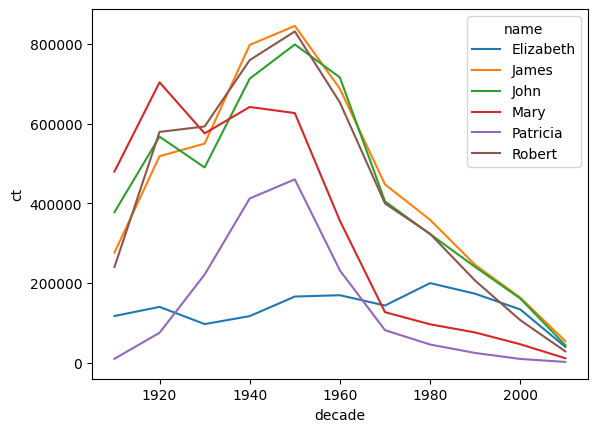

In [13]:
%%fsql
SELECT name, decade, SUM(number) AS ct
FROM decade_df
GROUP BY name, decade
ORDER BY decade
OUTPUT USING sns:lineplot(x="decade",y="ct",hue="name")

### Productionizing SQL Queries


In [14]:
import fugue.api as fa
res = fa.fugue_sql("""
SELECT name, gender, SUM(number) AS ct
  FROM `{{table}}`
 GROUP BY name, gender

names = TAKE {{n}} ROWS PREPARTITION BY gender PRESORT ct DESC

SELECT name, year, SUM(number) AS ct
  FROM `{{table}}`
 WHERE name IN (SELECT name FROM names)
 GROUP BY name, year
 ORDER BY year
""", engine="bq", table=table, n=n)

In [15]:
fa.as_pandas(res).head()

,name,year,ct
0,Patricia,1910,260
1,John,1910,11479
2,Mary,1910,22906
3,Elizabeth,1910,5791
4,Robert,1910,5609


### Iterating on Big Data

In [16]:
%%fsql bq
SELECT *
FROM `{{table}}`
SAMPLE 1 PERCENT
YIELD LOCAL DATAFRAME AS test

Now we can use DuckDB for further iteration. This prevents us from having to query the table.

In [17]:
%%fsql duckdb
SELECT name, SUM(number) AS ct
FROM test
GROUP BY name
PRINT

,name:str,ct:long
0,Miriam,1073
1,Gladys,2451
2,Lillian,2879
3,Kathleen,14165
4,Lillie,654
5,Vera,1335
6,Maxine,1146
7,Charlotte,3050
8,Doris,1960
9,Lola,626


In [18]:
%%fsql bq
SELECT name, SUM(number) AS ct
FROM `{{table}}`
GROUP BY name
PRINT

,name:str,ct:long
0,Sadie,80812
1,Mary,3737679
2,Vera,113065
3,Marie,461458
4,Lucille,194358
5,Virginia,621448
6,Margaret,1120766
7,Mildred,394772
8,Sallie,30201
9,Edith,211150


### Combining BigQuery and Distributed Compute

Now we can use Spark, Dask, or Ray to consume the BigQuery table and run Python libraries on it. This set-up can be used for distributed profiling or machine learning inference on top of BigQuery data.

In [20]:
import pandas as pd
from typing import List, Any

# schema: *
def median(df:pd.DataFrame) -> List[List[Any]]:
    return [[df.state.iloc[0], df.number.median()]]

fa.transform(
    ("bq", """SELECT state, number
    FROM `bigquery-public-data.usa_names.usa_1910_2013` TABLESAMPLE SYSTEM (1 PERCENT)"""),
    median,
    partition="state",
    engine="dask"
).compute().head()

,state,number
0,AK,9
1,AL,13
2,AR,12
3,AZ,12
4,CA,13
